In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBRegressor

from src.models import (
    Baseline,
    plot_metrics_model,
    plot_unit_model,
    plot_importance,
    get_feature_importance,
    remove_low_importance,
)

In [2]:
df = pd.read_csv('../data/processed/train_FD001_features.csv')
df.head()

,unit_number,time_cycles,sensor_4_mean_5,sensor_11_mean_5,sensor_15_mean_5,sensor_21_mean_5,sensor_17_mean_5,sensor_20_mean_5,sensor_3_mean_5,sensor_2_mean_5,...,sensor_13_mean_5,sensor_3,sensor_8,sensor_13,sensor_9_mean_5,sensor_9,sensor_14_mean_5,sensor_14,sensor_14_std_5,RUL
0,1,1,1400.600000,47.470,8.419500,23.419000,392.000000,39.060000,1589.700000,641.820000,...,2388.020,1589.70,2388.06,2388.02,9046.190000,9046.19,8138.620000,8138.62,0.000000,120
1,1,2,1401.870000,47.480,8.425650,23.421300,392.000000,39.030000,1590.760000,641.985000,...,2388.045,1591.82,2388.04,2388.07,9045.130000,9044.07,8135.055000,8131.49,5.041671,120
2,1,3,1402.646667,47.410,8.423033,23.395600,391.333333,39.003333,1589.836667,642.106667,...,2388.040,1587.99,2388.08,2388.03,9047.733333,9052.94,8134.446667,8133.23,3.717450,120
3,1,4,1402.452500,47.340,8.409325,23.390175,391.500000,38.972500,1588.075000,642.167500,...,2388.050,1582.79,2388.11,2388.08,9048.170000,9049.48,8134.292500,8133.83,3.050906,120
4,1,5,1403.206000,47.328,8.413340,23.393020,391.800000,38.958000,1587.030000,642.208000,...,2388.048,1582.85,2388.06,2388.04,9049.566000,9055.15,8134.194000,8133.80,2.651326,120


In [3]:
units = df['unit_number'].unique()

train_units, test_units = train_test_split(units, test_size=0.2, random_state=42)

train_df = df[df['unit_number'].isin(train_units)]
test_df  = df[df['unit_number'].isin(test_units)]

In [4]:
scaler = StandardScaler()

X_train = train_df.drop(columns=['unit_number','time_cycles','RUL'])
X_train_scaled = scaler.fit_transform(X_train)
y_train = train_df['RUL']

X_test = test_df.drop(columns=['unit_number','time_cycles','RUL'])
X_test_scaled  = scaler.transform(X_test)
y_test = test_df['RUL']

print(X_train.shape, X_test.shape)

(16561, 29) (4070, 29)


Baseline metrics
RMSE_train: 39.84204596539162 RMSE_test: 39.919400484650964
MAE_train : 35.25410871849815 MAE_test : 35.25728054440089
R2_train  : 0.0 R2_test  : -0.00022999362190279093


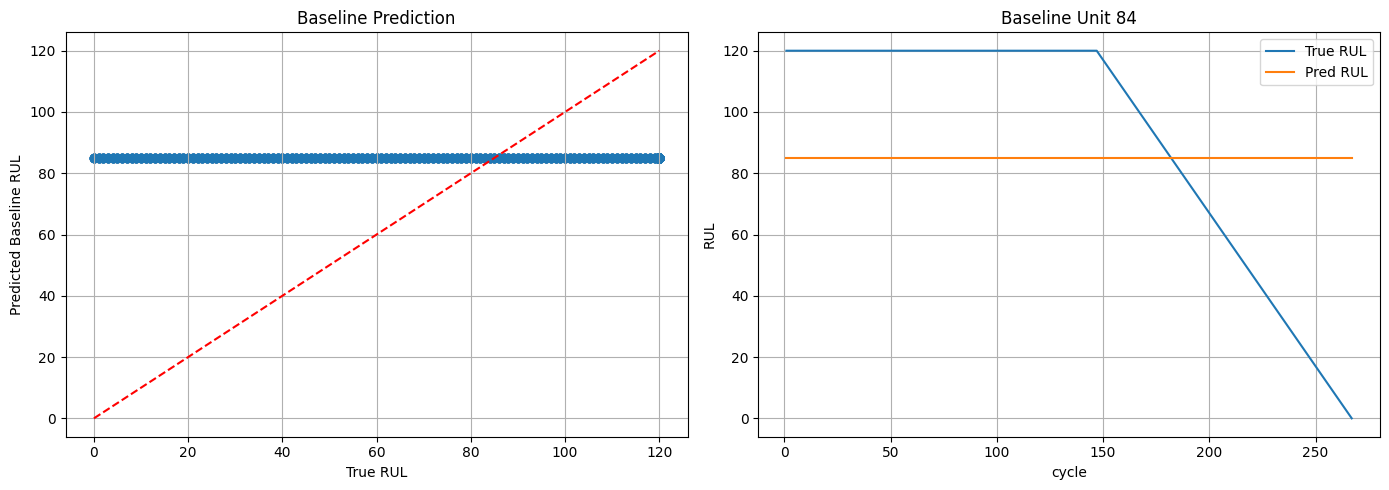

In [5]:
# Baseline

baseline = Baseline().fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(14,5))
plot_metrics_model(baseline, X_train, X_test, y_train, y_test, name="Baseline", ax=axes[0])
plot_unit_model(baseline, test_df, test_units[0], X_train.columns, scaler=None, name="Baseline", ax=axes[1])

plt.tight_layout()
plt.show()
plt.close()

Linear Regression metrics
RMSE_train: 20.144801605625606 RMSE_test: 19.00343158229487
MAE_train : 16.558041516816417 MAE_test : 15.39267634634452
R2_train  : 0.7443518084342629 R2_test  : 0.7733290232842651


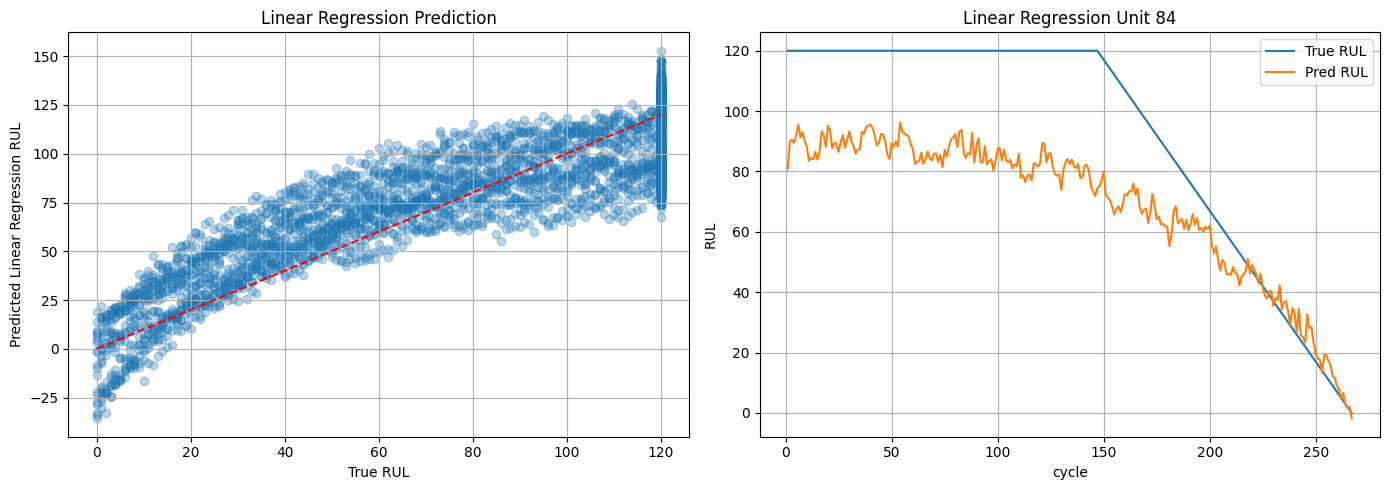

In [6]:
# Linear regression

lr = LinearRegression().fit(X_train_scaled, y_train)

fig, axes = plt.subplots(1, 2, figsize=(14,5))
plot_metrics_model(lr, X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression", ax=axes[0])
plot_unit_model(lr, test_df, test_units[0], X_train.columns, scaler, "Linear Regression", ax=axes[1])

plt.tight_layout()
plt.show()
plt.close()

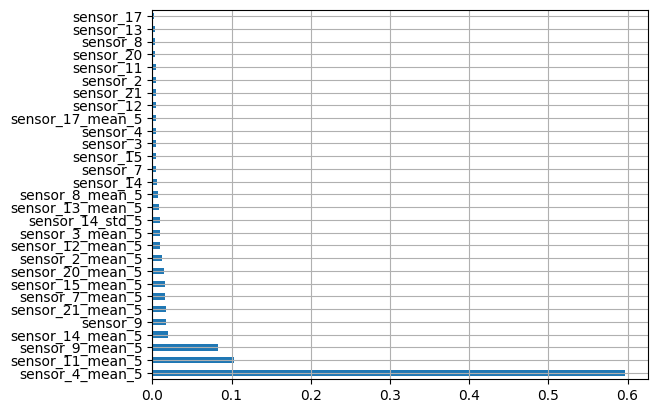

In [7]:
# Random Forest

rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
plot_importance(rf, X_train)

Random Forest metrics
RMSE_train: 5.255580311704599 RMSE_test: 15.804161831743283
MAE_train : 3.5636072700923855 MAE_test : 10.85517936117936
R2_train  : 0.9825996457653521 R2_test  : 0.8432257293550985


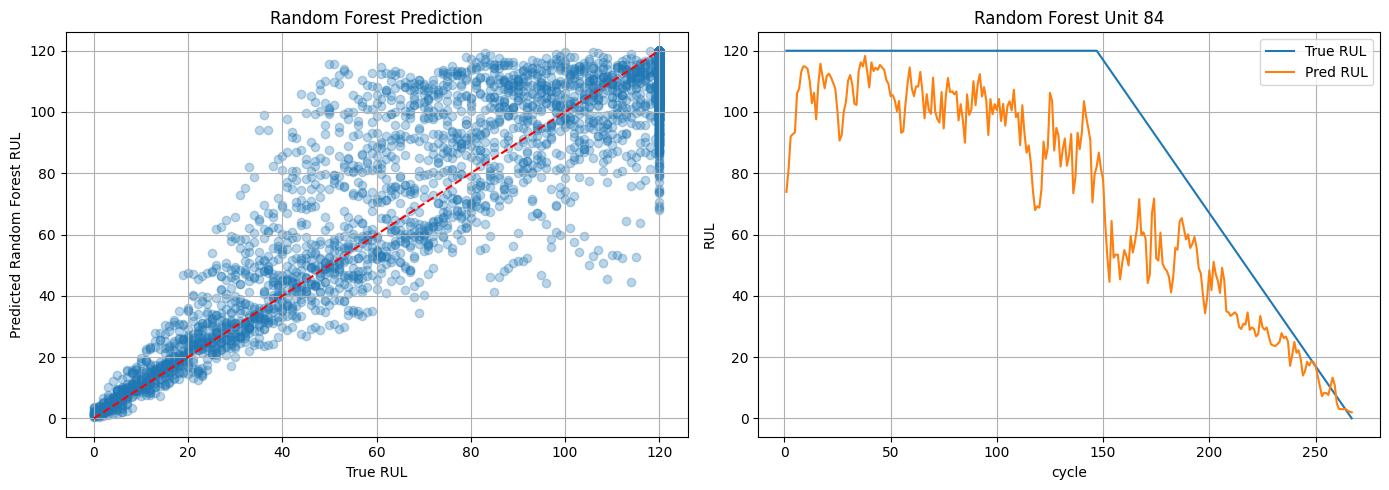

In [9]:
X_train_imp_rf, X_test_imp_rf = remove_low_importance(rf, X_train, X_test, top_n=15)

rf_vanilla = RandomForestRegressor().fit(X_train_imp_rf, y_train)

fig, axes = plt.subplots(1, 2, figsize=(14,5))
plot_metrics_model(rf_vanilla, X_train_imp_rf, X_test_imp_rf, y_train, y_test, "Random Forest", ax=axes[0])
plot_unit_model(rf_vanilla, test_df, test_units[0], X_train_imp_rf.columns, None, "Random Forest", ax=axes[1])

plt.tight_layout()
plt.show()
plt.close()

In [10]:
# Random Forest Tuned

param_grid = {"n_estimators": [100, 200, 300], 
              "max_depth": [None, 10, 20], 
              "min_samples_leaf": [1, 3, 5]}

grid = GridSearchCV(RandomForestRegressor(random_state=42),
                    param_grid,
                    cv=3,
                    scoring="neg_root_mean_squared_error",
                    n_jobs=-1)

grid.fit(X_train_imp_rf, y_train)

print(grid.best_params_)
print(-grid.best_score_)

{'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 300}
17.809374183783003


RF Tuned metrics
RMSE_train: 13.290758818373456 RMSE_test: 15.509101360413057
MAE_train : 9.154018201093395 MAE_test : 10.708866845350844
R2_train  : 0.888720211927899 R2_test  : 0.8490249710990161


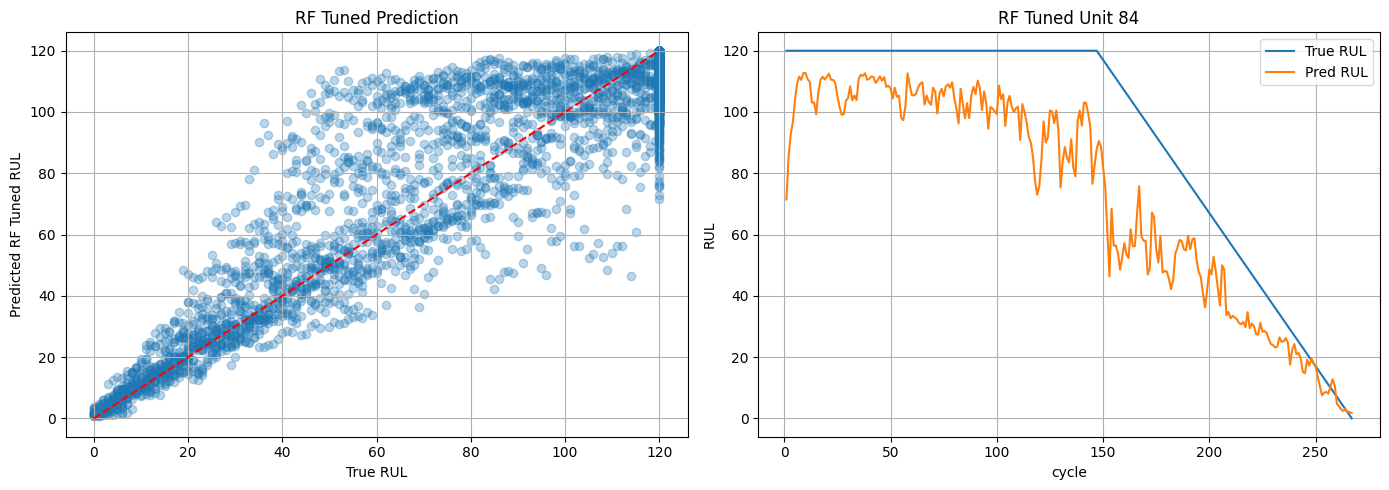

In [11]:
best_rf = grid.best_estimator_

fig, axes = plt.subplots(1, 2, figsize=(14,5))
plot_metrics_model(best_rf, X_train_imp_rf, X_test_imp_rf, y_train, y_test, "RF Tuned", ax=axes[0])
plot_unit_model(best_rf, test_df, test_units[0], X_train_imp_rf.columns, None, "RF Tuned", ax=axes[1])

plt.tight_layout()
plt.show()
plt.close()

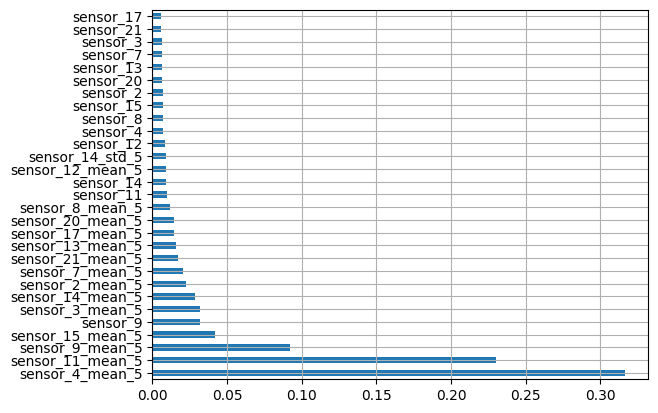

In [12]:
# XGBoost

xgb_ = XGBRegressor().fit(X_train, y_train)
plot_importance(xgb_, X_train)

XGBoost metrics
RMSE_train: 8.840569561177357 RMSE_test: 16.76199048296985
MAE_train : 6.071855545043945 MAE_test : 11.46268081665039
R2_train  : 0.9507646560668945 R2_test  : 0.8236469030380249


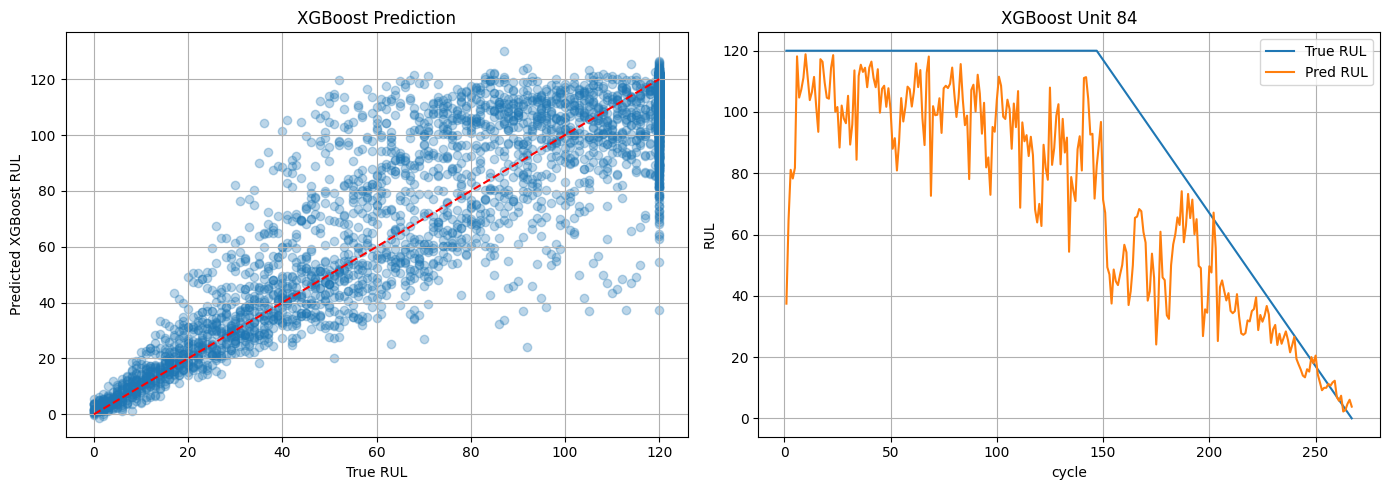

In [15]:
X_train_imp_xgb, X_test_imp_xgb = remove_low_importance(xgb_, X_train, X_test, top_n=15)
xgb_vanilla = XGBRegressor().fit(X_train_imp_xgb, y_train)

fig, axes = plt.subplots(1, 2, figsize=(14,5))
plot_metrics_model(xgb_vanilla, X_train_imp_xgb, X_test_imp_xgb, y_train, y_test, "XGBoost", ax=axes[0])
plot_unit_model(xgb_vanilla, test_df, test_units[0], X_train_imp_xgb.columns, None, "XGBoost", ax=axes[1])

plt.tight_layout()
plt.show()
plt.close()

In [16]:
# XGBoost Tuned

param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1, 0.2],
}

grid_xgb = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid_xgb,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_xgb.fit(X_train_imp_xgb, y_train)

print("Best params:", grid_xgb.best_params_)
print("Best RMSE (CV):", -grid_xgb.best_score_)

best_xgb = grid_xgb.best_estimator_

Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best RMSE (CV): 17.583140691121418


XGBoost Tuned metrics
RMSE_train: 16.219142313716166 RMSE_test: 15.582125258239858
MAE_train : 11.726157188415527 MAE_test : 11.218445777893066
R2_train  : 0.8342809677124023 R2_test  : 0.8475999236106873


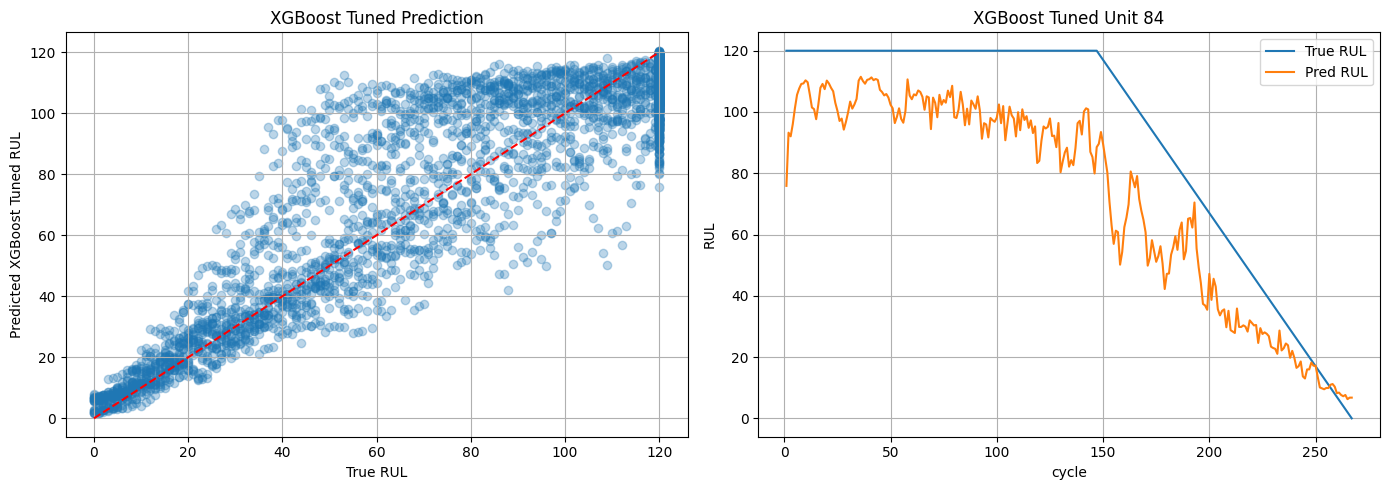

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
plot_metrics_model(best_xgb, X_train_imp_xgb, X_test_imp_xgb, y_train, y_test, "XGBoost Tuned", ax=axes[0])
plot_unit_model(best_xgb, test_df, test_units[0], X_train_imp_xgb.columns, None, "XGBoost Tuned", ax=axes[1])
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# LSTM

